In [37]:
import numpy as np
import os
from scipy import signal
import UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *
from scipy.optimize import curve_fit

In [38]:
year = 2021
packets = import_data(f'/Users/joshuagoodwill/packets/{year}_packet.json')

sw_num = 1000
V_arr = np.array(packets['packets']['Medium'][f'{sw_num}']['Voltage'])
I_arr = np.array(packets['packets']['Medium'][f'{sw_num}']['Current0'])

In [39]:
'''
def geN_fit(x, y):
Generates fit of linear and sqrt portion of IV arrays. Refer to
data_processing to idenify filtering of IV arrays. scipy.optimize.curve_fit
used to fit non-linear least squares to fit

input:
V_arr (array); Voltage array
I_arr (array); Current array

output:
V_fit (np.array); linear space between min and max voltages from V_arr
model(t, *popt) (np.array); fitted model of I_arr using Voltage range and 
                            pointer to popt
popt(array); optimal values for parameters
  V_f = popt[0]; Plasma potential
  I_p = popt[1]; Current at Floating 
  
pcov(2D np.array); covariance of popt array
'''

def gen_fit(V_arr, I_arr):
    # V_proc, I_proc = data_processing(V_arr, I_arr)
    V_proc, I_proc = (V_arr[V_arr < 4], I_arr[V_arr < 4])
    guess = [0.6,-14,80, 5*(10**10),1000,-0.5]    #intial guess
    b = ((-3,-np.inf,-np.inf,0,0,-3),(3,np.inf,np.inf,np.inf,10000,3)) #bounds
    popt, pcov = curve_fit(model, V_proc, I_proc, guess, bounds = b)
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 50) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov, V_proc, I_proc

'''
def model(V_proc, VP, m1, b, ne, etemp, V0):
Model to fit ion, *transition*, electron saturation regions

input:
V_proc (np.array); processed V_arr for fitting
Vf (float); floating potential
m1 (float); slope of linear fit
b  (float); y-intercept of linear fit
ne (float); electron density [cm^{-2}]
etemp(float); electron temperature [K]
VP (float); negative plasma potential [V]
'''

def model(V_proc, Vf, m1, b, ne, etemp, VP):
    I_fit = np.zeros(len(V_proc))
    #Linear fit for ion saturation
    I_fit[V_proc <= Vf] = lin_fit(V_proc[V_proc <= Vf], m1, b) 
    #Sqrt fit for electron saturation
    I_fit[V_proc > Vf] = sqrt_fit(V_proc[V_proc > Vf], ne, etemp ,VP) \
                         - sqrt_fit(Vf, ne , etemp, VP)
    return I_fit

def lin_fit(x, m, y_int): #linear--full model square root
    return m * x + y_int

'''
def sqrt_fit(x, ne, etemp, V0)
Uses Eq. 1.4 and 1.5 of https://digitalcommons.usu.edu/etd/274

input:
x (np.array); V_proc [V]
ne (float); electron density [cm?]
etemp(float); electron temperature [K]
VP (float); negative plasma potential [V]

output:
I (float); current fit [nA]
'''
def sqrt_fit(x, ne, etemp, VP):# square root
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    m_e = 9.109 * 10**-31 #electron mass [kg]              
    R = (3./16.) * 0.0254 #radius of probe [cm?]
    L = (3.25) * 0.0254 #length of probe [cm?]
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

    k = q_e / (K_b * etemp)
    I0 = ne * q_e * np.sqrt(K_b * etemp / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x + VP))

'''
def data_processing()
'''

def data_processing(x_raw,y_raw):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
    max_ind = np.argmax(y_raw) #find index of maximum y
    if (max_ind.size != 1):
        min_max_val = np.argmin(x_raw[max_ind]) #find minimum x of max y
    else:
        min_max_val = max_ind
    ind_high = np.where(x_raw > x_raw[min_max_val] + 0.1) # find indexs of x greater than 0.1 more than max y
    ind_low = np.where(x_raw < 0) #find indexs of x less than 0
    ind_rem = np.concatenate((ind_high,ind_low),axis=None)
    x = np.delete(x_raw,ind_rem) #remove from x
    y = np.delete(y_raw,ind_rem) #remove from y
    return x,y

In [40]:
V_fit, I_fit, params, cov, V_proc, I_proc = generate_fit(V_arr, I_arr)
# generate_fit(V_arr, I_arr)

In [41]:
# print(V_fit)
# print(I_fit)
print(params[0])

0.5337970277539371


In [42]:
n = 7
print(V_fit[n], I_fit[n])
Vf = 8
print(V_fit[Vf], I_fit[Vf])
print(params)

-4.341508066513553 -283.1865821063436
-4.143013728345958 -272.5993354121564
[ 5.33797028e-01  5.33377767e+01 -5.16201941e+01  6.12447853e+10
  8.97936516e+02 -5.67765699e-01]


In [43]:
# x = np.linspace(0, 0.6, 100)
# m = 224
# b = -100
# y = m * x + b

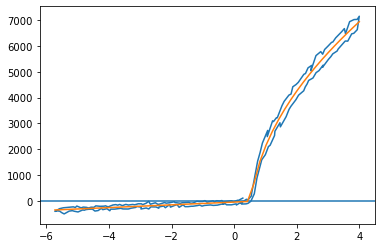

In [44]:
plt.axhline(0)
# plt.plot(x,y)
# plt.plot(V_arr, I_arr)
plt.plot(V_proc, I_proc)
plt.plot(V_fit, I_fit)
# plt.ylim(-100, 1000)
# plt.xlim(0, 1)

In [45]:
print(I_fit[(V_fit < 0.1) & (V_fit > -0.1)])

[-50.26715483]
